# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(' Number of rows in Azdias {}'.format(len(azdias)),'\n',
      'Number of columns in Azidas {}'.format(len(azdias.columns)),'\n \n',
     'Number of rows in Feature Summary {}'.format(len(feat_info)), '\n',
      'Number of columns in Feature Summary {}'.format(len(feat_info.columns)))

 Number of rows in Azdias 891221 
 Number of columns in Azidas 85 
 
 Number of rows in Feature Summary 85 
 Number of columns in Feature Summary 4


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
# Create a new copy of the data set for cleaning
azdias_clean = pd.DataFrame(azdias)

In [7]:
print('Naturally missing value count is: {}'.format(azdias_clean.isnull().sum().sum()))

Naturally missing value count is: 4896838


In [8]:
# Creating for loop to iterate through Azdias dataset and replace values with NaN
## Ref: https://knowledge.udacity.com/questions/98491
### Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
for index in feat_info.index:
    # Clean brackets and split by ',' for STR format -> list
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias_clean.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [9]:
azdias_clean.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
print('Converted missing value count is: {}'.format(azdias_clean.isnull().sum().sum()))

Converted missing value count is: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_values = azdias_clean.isnull().sum()
null_values

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
print('Percentage of missing values per column is: {}'.format(null_values / len(azdias_clean)*100))

Percentage of missing values per column is: AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT  

In [13]:
null_values = null_values / len(azdias_clean)*100

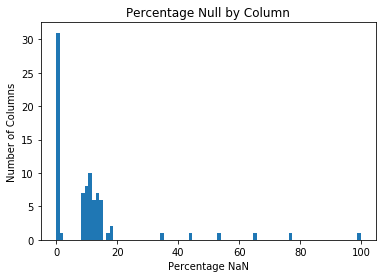

In [14]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(null_values, bins = 85)
plt.title('Percentage Null by Column')
plt.xlabel('Percentage NaN')
plt.ylabel('Number of Columns');

In [15]:
to_drop = null_values[null_values > 20]
print('These columns are >20% null. Will drop:\n{}'.format(to_drop))

These columns are >20% null. Will drop:
AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
to_drop = to_drop.index
azdias_clean.drop(to_drop, axis=1, inplace=True)

azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Most of the columns had a relatively minor proportion of null values compared to the whole. There were 6 columns that contained >20% null values. I've considered these to be outliers and dropped them. Column name and percentage null is:<br>

AGER_TYP: 76.955435<br>
GEBURTSJAHR: 44.020282<br>
TITEL_KZ: 99.757636<br>
ALTER_HH:34.813699<br>
KK_KUNDENTYP: 65.596749<br>
KBA05_BAUMAX: 53.468668<br>

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
# How much data is missing in each row of the dataset?
row_null = azdias_clean.isnull().sum(axis=1)

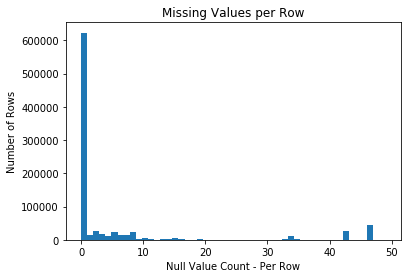

In [18]:
plt.hist(row_null, bins=50)
plt.title('Missing Values per Row')
plt.xlabel('Null Value Count - Per Row')
plt.ylabel('Number of Rows');

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lt20 = azdias_clean[row_null < 20]
azdias_mte20 = azdias_clean[row_null >= 20]

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_zero = null_values[null_values == 0].index
compare_cols = no_zero[:6]

In [21]:
def hist_create(column):
    figure, (fig1, fig2) = plt.subplots(1,2)
    figure.set_figwidth(12)
    
    fig1.set_title('<20 Missing Values')
    sns.countplot(azdias_clean.loc[azdias_lt20.index, column], ax = fig1);
    
    fig2.set_title('>= 20 Missing Values')
    sns.countplot(azdias_clean.loc[azdias_mte20.index, column], ax = fig2);

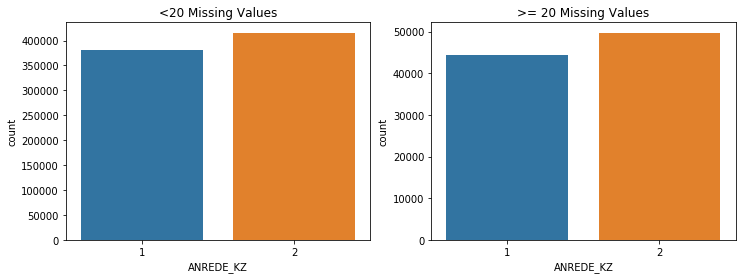

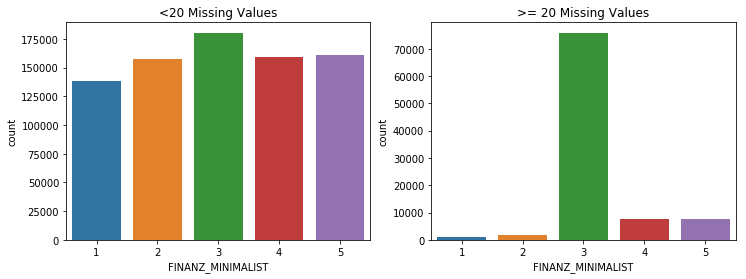

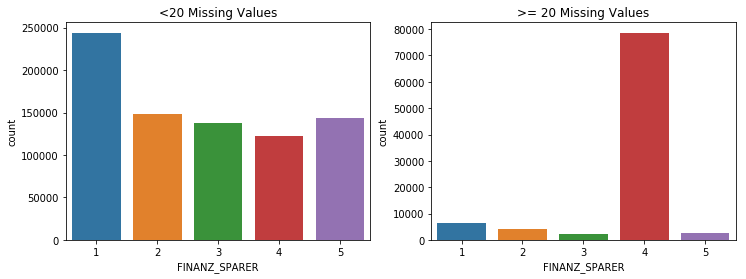

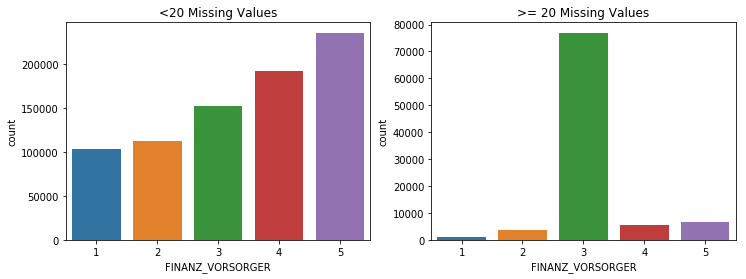

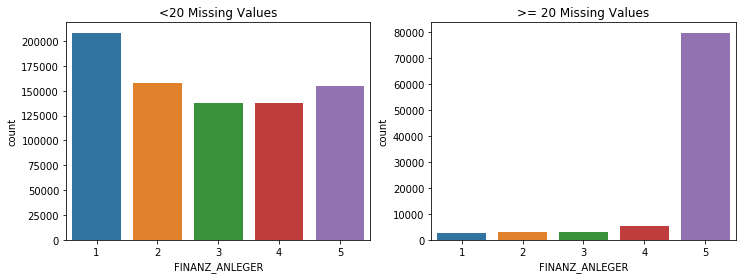

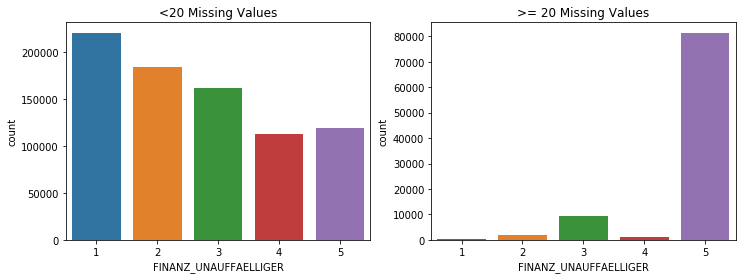

In [22]:
for i in range(compare_cols.size):
    hist_create(compare_cols[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

*Note: The Y-value counts are different between the two subsets of data.*

The distributions of non-missing features is not similar to the distribution of missing values. Per project specifications, we should indicate this as *special* for analytical purposes. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
azdias_clean = pd.DataFrame(azdias_lt20)

In [24]:
# Updating feat_info to only include rows with >20 missing values
feat_info_clean = feat_info[feat_info.attribute.isin(azdias_clean.columns)]

In [25]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_var = feat_info_clean[feat_info_clean.type == 'categorical'].attribute
categorical_var

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.
cat_bi = []
cat_multi = []

for var in categorical_var:
    if azdias_clean[var].nunique() > 2:
        cat_multi.append(var)
    else: 
        cat_bi.append(var)

In [28]:
# View value counts for categorical - binary set
for var in cat_bi:
    print(azdias_clean[var].value_counts())

2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
0.0    790370
1.0      6707
Name: SOHO_KZ, dtype: int64
2.0    394116
1.0    366623
Name: VERS_TYP, dtype: int64
W    628695
O    168382
Name: OST_WEST_KZ, dtype: int64


In [29]:
# Update binary columns to use either 0 or 1
azdias_clean['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias_clean['SOHO_KZ'].replace([0.0, 1.0], [0,1], inplace=True)
azdias_clean['VERS_TYP'].replace([2.0,1.0],[1,0], inplace=True)
azdias_clean['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

In [30]:
for var in cat_multi:
    print(azdias_clean[var].value_counts())

4.0    198089
3.0    147068
2.0    141166
5.0    111032
6.0    101898
1.0     93192
Name: CJT_GESAMTTYP, dtype: int64
6    289004
1    196805
5    106220
2    104577
4     55874
3     44597
Name: FINANZTYP, dtype: int64
12.0    129983
10.0    102748
8.0      82992
11.0     75051
5.0      70468
4.0      60413
9.0      57046
3.0      53094
1.0      50640
2.0      43647
7.0      40642
6.0      25721
Name: GFK_URLAUBERTYP, dtype: int64
1.0     402248
10.0    128902
2.0      98491
11.0     48727
8.0      21777
7.0      19568
4.0      11573
5.0      11164
9.0      10451
6.0       8512
3.0       4682
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402248
5.0    188080
2.0     98491
4.0     49857
3.0     27419
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206766
9.0     136229
10.0    111538
2.0     111016
4.0      73938
3.0      68893
6.0      28870
5.0      27472
8.0      18525
7.0       9198
Name: LP_STATUS_FEIN, dtype: int64
1.0    317782
2.0    170303
4.0    154754
5.0    111538
3.0     38068
Na

In [31]:
for var in cat_multi:
    azdias_clean = azdias_clean.drop(var, axis=1)

In [32]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

For binary categorical features, I updated the value set to either use 0, or 1, as to make the set legible by the algorithmn. For the multi categorical features (with >2 value potentials), I simply dropped those columns. I could have encoded them with dummy variables, however for the sake of simplicity I chose to just drop them.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [34]:
decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

In [35]:
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

In [36]:
azdias_clean['DECADE'].replace(decade_dic, inplace = True)
azdias_clean['MOVEMENT'].replace(movement_dic, inplace = True)

In [37]:
azdias_clean.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [38]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
1,1.0,1,1,5,2,5,4,5,0,3.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0


In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [40]:
wealth_dic = {'11':1, '12':1, '13':1, '14':1, '15':1, 
             '21':2, '22': 2, '23': 2, '24':2, '25':2,
             '31':3, '32':3, '33':3,'34':3, '35':3,
             '41':4, '42':4, '43':4, '44':4, '45':4,
             '51':5, '52':5,'53':5, '54':5, '55':5}

life_dic = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
            '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
            '51':1, '52':2, '53':3, '54':4, '55':5}

In [41]:
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']

In [42]:
azdias_clean['WEALTH'].replace(wealth_dic, inplace = True)
azdias_clean['LIFE_STAGE'].replace(life_dic, inplace = True)

In [43]:
azdias_clean.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [44]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

The values in both `CAMEO_INTL_2015` and `PRAEGENDE_JUGENDJAHRE` were not interpretable by the algorithmn in their initial state. Encoding them to a more specified numerical value system will allow us to use these fields in our learning process. After encoding them to new columns (Decade, Movement, Wealth, and Life_Stage), I dropped the original columns as they were no longer useful. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
feat_info_clean.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_feat = feat_info_clean[feat_info_clean.type == 'mixed']

mixed_feat

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [47]:
for var in mixed_feat['attribute']:
    if var in azdias_clean.columns:
        azdias_clean.drop(var, axis = 1, inplace = True)

In [48]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Creating for loop to iterate through Azdias dataset and replace values with NaN
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
        for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
            try:
                feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
            except:
                continue
        df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df.drop(columns = to_drop, axis = 'columns', inplace = True)
    
    row_null = df.isnull().sum(axis=1)
    df_clean = df[row_null < 20]

    
    # select, re-encode, and engineer column values.
    categorical_var = feat_info_clean[feat_info_clean.type == 'categorical'].attribute
    cat_bi = []
    cat_multi = []

    for var in categorical_var:
        if df_clean[var].nunique() > 2:
            cat_multi.append(var)
        else: 
            cat_bi.append(var)

    df_clean['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    df_clean['SOHO_KZ'].replace([0.0, 1.0], [0,1], inplace=True)
    df_clean['VERS_TYP'].replace([2.0,1.0],[1,0], inplace=True)
    df_clean['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

    for var in cat_multi:
        df_clean = df_clean.drop(var, axis=1)
        
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']

    df_clean['DECADE'].replace(decade_dic, inplace = True)
    df_clean['MOVEMENT'].replace(movement_dic, inplace = True)

    df_clean.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

    wealth_dic = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                 '21':2, '22': 2, '23': 2, '24':2, '25':2,
                 '31':3, '32':3, '33':3,'34':3, '35':3,
                 '41':4, '42':4, '43':4, '44':4, '45':4,
                 '51':5, '52':5,'53':5, '54':5, '55':5}

    life_dic = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                '51':1, '52':2, '53':3, '54':4, '55':5}

    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']

    df_clean['WEALTH'].replace(wealth_dic, inplace = True)
    df_clean['LIFE_STAGE'].replace(life_dic, inplace = True)

    df_clean.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    
    mixed_feat = feat_info_clean[feat_info_clean.type == 'mixed']
    for var in mixed_feat['attribute']:
        if var in df_clean.columns:
            df_clean.drop(var, axis = 1, inplace = True)

    
    # Return the cleaned dataframe.
    return df_clean

In [50]:
# Load in the general demographics data.
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [51]:
testing  = clean_data(azdias_test)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [52]:
testing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,1,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [53]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean = azdias_clean.fillna(azdias_clean.mode().iloc[0])
azdias_clean.isnull().sum().sum()

0

In [54]:
# Apply feature scaling to the general population demographics data.
scale = StandardScaler()
feat_scaled = scale.fit_transform(azdias_clean)

In [55]:
azdias_scaled = pd.DataFrame(feat_scaled, columns = azdias_clean.columns)

In [56]:
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,0.441346,1.454540,0.573590,-0.171711,-0.127228,0.684698,1.098802,0.530654,1.175857,-1.249369
1,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,-0.935871,0.418829,0.573590,-0.171711,-0.127228,-0.789243,1.098802,-1.884467,-0.869590,0.766691
2,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.935871,-0.616882,0.573590,-1.173497,-0.997766,-0.052273,-0.267171,0.530654,-1.551406,-0.577349
3,0.200733,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.010291,...,0.441346,-0.616882,-0.337417,0.830075,0.308041,1.421668,-0.267171,0.530654,0.494041,0.094671
4,-1.766173,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.010291,...,0.441346,1.454540,1.484596,-1.173497,-0.997766,-0.052273,-1.633144,0.530654,1.175857,0.766691


### Discussion 2.1: Apply Feature Scaling

I ended up filling all NaN values with the column mode using fillna(). Then I used the StandardScaler as recommended for the feature scaling 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

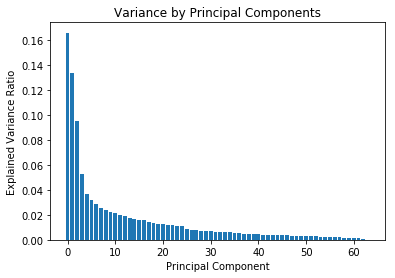

In [58]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title('Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio');

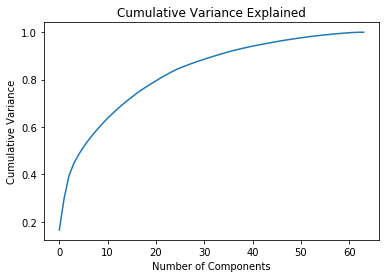

In [59]:
#Ref: https://www.geeksforgeeks.org/numpy-cumsum-in-python/
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance');

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca30 = PCA(n_components = 30)
azdias_pca = pca30.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction
I am retaining 30 principal components. Per our visualizations above, keeping 30 will still allow us to retain over 85% of the variances, while reducing our feature set by about half. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weight(df, pca, x):
    weighted = pd.DataFrame(pca.components_, columns = df.columns).iloc[x]
    weighted.sort_values(ascending = False, inplace = True)
    return weighted

In [62]:
pca_weight(azdias_scaled, pca30, 0)

PLZ8_ANTG3               0.225336
PLZ8_ANTG4               0.216968
WEALTH                   0.204733
HH_EINKOMMEN_SCORE       0.202297
ORTSGR_KLS9              0.196761
EWDICHTE                 0.194653
FINANZ_HAUSBAUER         0.159627
KBA05_ANTG4              0.153998
PLZ8_ANTG2               0.153669
FINANZ_SPARER            0.152961
ARBEIT                   0.142577
KBA05_ANTG3              0.136748
ANZ_HAUSHALTE_AKTIV      0.136046
RELAT_AB                 0.134956
SEMIO_PFLICHT            0.121032
SEMIO_REL                0.118469
DECADE                   0.112152
MOVEMENT                 0.110231
SEMIO_RAT                0.099457
SEMIO_TRADV              0.093601
SEMIO_MAT                0.082373
FINANZ_UNAUFFAELLIGER    0.080959
SEMIO_FAM                0.080952
SEMIO_KULT               0.075449
FINANZ_ANLEGER           0.074962
REGIOTYP                 0.060347
SEMIO_SOZ                0.043283
PLZ8_HHZ                 0.042243
HEALTH_TYP               0.041131
KKK           

In [63]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight(azdias_scaled, pca30, 1)

ALTERSKATEGORIE_GROB     0.256319
SEMIO_ERL                0.229960
FINANZ_VORSORGER         0.229253
SEMIO_LUST               0.180171
RETOURTYP_BK_S           0.161940
FINANZ_HAUSBAUER         0.121706
SEMIO_KRIT               0.117970
SEMIO_KAEM               0.116432
W_KEIT_KIND_HH           0.114797
PLZ8_ANTG3               0.098301
EWDICHTE                 0.097774
ORTSGR_KLS9              0.096467
PLZ8_ANTG4               0.096093
ANREDE_KZ                0.093188
WEALTH                   0.079073
KBA05_ANTG4              0.075120
SEMIO_DOM                0.074493
ARBEIT                   0.071707
RELAT_AB                 0.069200
PLZ8_ANTG2               0.068096
ANZ_HAUSHALTE_AKTIV      0.066355
HH_EINKOMMEN_SCORE       0.061773
FINANZ_MINIMALIST        0.059451
WOHNDAUER_2008           0.058526
KBA05_ANTG3              0.050462
VERS_TYP                 0.032258
ANZ_HH_TITEL             0.032046
MOVEMENT                 0.018318
PLZ8_HHZ                 0.015838
REGIOTYP      

In [64]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight(azdias_scaled, pca30, 2)

SEMIO_VERT               0.344684
SEMIO_SOZ                0.261933
SEMIO_FAM                0.248881
SEMIO_KULT               0.233825
FINANZ_MINIMALIST        0.154541
RETOURTYP_BK_S           0.109176
FINANZ_VORSORGER         0.101759
W_KEIT_KIND_HH           0.085212
ALTERSKATEGORIE_GROB     0.079763
SEMIO_REL                0.067873
SEMIO_LUST               0.064609
SEMIO_MAT                0.055579
ORTSGR_KLS9              0.050247
EWDICHTE                 0.049464
PLZ8_ANTG4               0.049091
PLZ8_ANTG3               0.048442
GREEN_AVANTGARDE         0.047130
ARBEIT                   0.037292
RELAT_AB                 0.034324
PLZ8_ANTG2               0.032686
WOHNDAUER_2008           0.032604
WEALTH                   0.030116
KBA05_ANTG4              0.029940
ANZ_HAUSHALTE_AKTIV      0.026769
ANZ_HH_TITEL             0.013917
KBA05_ANTG3              0.011798
ANZ_TITEL                0.009733
PLZ8_HHZ                 0.005550
VERS_TYP                 0.001940
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

#### Component 1:
It appears that the first component has a relationship with various wealth factors
##### Positive Correlation:
- PLZ8_ANTG3 
    - Number of 6-10 family homes
- PLZ8_ANTG4
    - Number of 10+ family homes
- WEALTH
    - Family or household wealth
    
##### Negative Correlation:
- MOBI_REGIO
    - Movement patterns
- PLZ8_ANTG1
    - Number of 1-2 family homes
- FINANZ_MINIMALIST
    - Financial typology

#### Component 2:
It appears that this component has a relationship to age, personality, and financial typology
##### Positive Correlation:
- ALTERSKATEGORIE_GROB 
    - Estimated age based on given name analysis 
- SEMIO_ERL 
    - Personality typology: event-oriented              
- FINANZ_VORSORGER 
    - Financial typology: be prepared  

##### Negative Correlation:
- FINANZ_SPARER 
    - Financial typology, money-saver         
- DECADE 
    - generation           
- SEMIO_REL 
    - Personality typology, religious     

#### Component 3:
The third component appears to be associated with personality types and gender
##### Positive Correlation:
- SEMIO_VERT  
    - Personality typology, dreamful
- SEMIO_SOZ  
    - Personality typology, socially-minded
- SEMIO_FAM 
    - Personality typology, family-minded

##### Negative Correlation:
- SEMIO_DOM 
    - Personality typology, dominant-minded            
- SEMIO_KAEM 
    - Personality typology, combative attitude             
- ANREDE_KZ 
    - Gender    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [65]:
# Over a number of different cluster counts...
def k_cluster(pca_data, cluster):
    # run k-means clustering on the data and...
    kmean = KMeans(n_clusters = cluster)
    mod = kmean.fit(pca_data)    
    # compute the average within-cluster distances.
    score = np.abs(mod.score(pca_data))
    return score
    

In [66]:
test_range = list(range(1,20))
scores = []
for i in test_range:
    scores.append(k_cluster(azdias_pca, i))

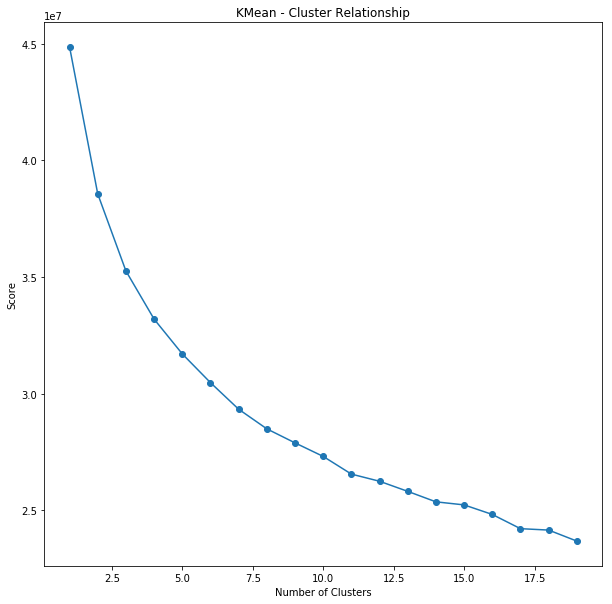

In [82]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,10))
plt.plot(test_range, scores, marker='o')
plt.title('KMean - Cluster Relationship')
plt.xlabel('Number of Clusters')
plt.ylabel('Score');

In [83]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmean = KMeans(n_clusters = 10)
mod = kmean.fit(azdias_pca)
azdias_predict = mod.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

`Attempt 1:` I attempted to review the visualization above to find the elbow. I believe the elbow to be around 16. It was a little difficult to tell, but I chose 16 clusters for this reason

`Attempt 2`: After instructor feedback, I updated my original testing range to (1,20). With this expanded view, I believe the elbow is actually around 10. So after review I have updated my n_clusters to 10

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [84]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [85]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [86]:
customers_clean = customers_clean.fillna(customers_clean.mode().iloc[0])
customers_clean.isnull().sum().sum()

0

In [87]:
#Scaling
customers_clean_scale = scale.transform(customers_clean)
customers_clean_scale = pd.DataFrame(customers_clean_scale, columns = customers_clean.columns)

#PCA 
customers_pca = pca30.transform(customers_clean_scale)

In [88]:
customers_predict = mod.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [89]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def compare_prop(gen_pop, cust_pop):
    figure, (fig1, fig2) = plt.subplots(1,2)
    figure.set_figwidth(12)
    
    fig1.set_title('General Clusters')
    sns.countplot(gen_pop, ax = fig1);
    
    fig2.set_title('Customer Clusters')
    sns.countplot(cust_pop, ax = fig2);


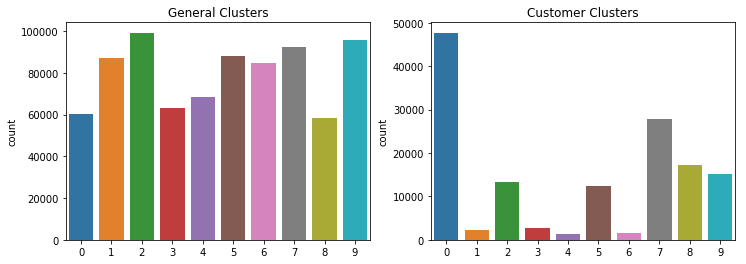

In [90]:
compare_prop(azdias_predict, customers_predict);

In [91]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_1 = scale.inverse_transform(pca30.inverse_transform(mod.cluster_centers_[1]))
centroid_1 = pd.Series(data = centroid_1, index = customers_clean.columns)
centroid_1.sort_values(ascending = False)

MIN_GEBAEUDEJAHR         1994.069544
KBA13_ANZAHL_PKW          720.733557
WOHNDAUER_2008              7.543365
SEMIO_RAT                   6.082386
SEMIO_PFLICHT               6.010867
SEMIO_DOM                   5.872549
DECADE                      5.694787
SEMIO_TRADV                 5.588886
SEMIO_KAEM                  5.548899
INNENSTADT                  5.477149
SEMIO_KRIT                  5.401084
SEMIO_REL                   5.238891
SEMIO_MAT                   5.009088
BALLRAUM                    4.969414
FINANZ_ANLEGER              4.423541
REGIOTYP                    4.404823
SEMIO_ERL                   4.373518
HH_EINKOMMEN_SCORE          4.047299
SEMIO_KULT                  4.003604
GEBAEUDETYP_RASTER          3.997176
FINANZ_SPARER               3.993940
ORTSGR_KLS9                 3.966572
FINANZ_UNAUFFAELLIGER       3.907781
PLZ8_GBZ                    3.897695
KBA05_GBZ                   3.830569
SEMIO_FAM                   3.758789
KONSUMNAEHE                 3.676772
M

In [94]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_4 = scale.inverse_transform(pca30.inverse_transform(mod.cluster_centers_[4]))
centroid_4 = pd.Series(data = centroid_12, index = customers_clean.columns)
centroid_4.sort_values(ascending = True)

ANREDE_KZ                  -0.024184
ANZ_TITEL                   0.001971
SOHO_KZ                     0.008066
ANZ_HH_TITEL                0.064269
GREEN_AVANTGARDE            0.117721
KBA05_ANTG1                 0.345169
VERS_TYP                    0.551581
KBA05_ANTG4                 0.648095
OST_WEST_KZ                 0.695140
MOVEMENT                    0.882279
KBA05_ANTG3                 1.116035
KBA05_ANTG2                 1.241635
PLZ8_ANTG4                  1.295984
ANZ_PERSONEN                1.413415
PLZ8_ANTG1                  1.434983
MOBI_REGIO                  1.687055
FINANZ_MINIMALIST           1.888319
ALTERSKATEGORIE_GROB        1.924830
LIFE_STAGE                  1.945171
KONSUMNAEHE                 2.078227
FINANZ_VORSORGER            2.127703
KBA05_GBZ                   2.139981
SEMIO_ERL                   2.336160
HEALTH_TYP                  2.418679
PLZ8_ANTG3                  2.431646
SEMIO_KAEM                  2.523990
PLZ8_GBZ                    2.661775
R

### Discussion 3.3: Compare Customer Data to Demographics Data

#### Cluster 1:
Cluster 1 is over represented in the customer data. Segments in this cluster that are relatively popular with the mail order company are:
- MIN_GEBAEUDEJAHR
    - First year building was mentioned in the database
- KBA13_ANZAHL_PKW
    - Number of cars in the PLZ8 region
- WOHNDAUER_2008
    - Length of residence


#### Cluster 4:
Cluster 4 is under represented in the customer data. Segments in this cluster that are relatively unpopular with the company are:
- ANZ_TITEL
    - Number of professional academic title holders in household    
- SOHO_KZ 
    - Small office / home office flag           
- ANREDE_KZ 
    - Gender    

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.